### ספריות

In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import fiona

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


### העלת משתנים להרצת הקוד

In [3]:
path = os.getcwd()

parent = os.path.dirname(path)

software_data_folder_location = os.path.dirname(parent)

df_inputs_outputs = pd.read_excel(r'{}\inputs_outputs.xlsx'.format(software_data_folder_location))

software_data_folder_location=df_inputs_outputs['location'][0]

forecast_version_folder_location=df_inputs_outputs['location'][1]

sys.path.append(software_data_folder_location)

### פונקציות

In [4]:
from py_scripts.statistical_areas_layer import statistical_areas_layer
from py_scripts.authority_level_information import authority_level_information
from py_scripts.upload_population_information import upload_population_information
from py_scripts.create_age_distribution_table import create_age_distribution_table
from py_scripts.percentage_of_hardi_of_statistical_area import percentage_of_hardi_of_statistical_area
from py_scripts.fix_level_a_arab_jerus import fix_level_a_arab_jerus
from py_scripts.assimilation_fix_level_a import assimilation_fix_level_a
from py_scripts.uploading_problematic_statistical_area_for_correction_level_b import uploading_problematic_statistical_area_for_correction_level_b
from py_scripts.create_GM_according_to_catalog import create_GM_according_to_catalog
from py_scripts.fix_lebel_b import fix_lebel_b
from py_scripts.creating_apartments_according_to_household_size import creating_apartments_according_to_household_size
from py_scripts.information_control_lms_at_authority_level import information_control_lms_at_authority_level
from py_scripts.export_stat_area_level_information import export_stat_area_level_information

from py_scripts.school import school


### פונקציות גלובליות

In [5]:
from functions import make_point
from functions import up_load_df
from functions import up_load_gdb
from functions import up_load_shp

In [6]:
def drop_geo(geoDF):
    geoDF = geoDF.drop(columns='geometry')
    return geoDF

In [7]:
def double_taz_num(df):
    dup_taz_num=df.groupby(['Taz_num']).size().reset_index(name='count').query('count>1').Taz_num.to_list()
    return df.loc[df['Taz_num'].isin(dup_taz_num)]

In [8]:
def make_point(df):
    df_point=df.copy()
    df_point['centroid'] = df_point.representative_point()
    df_point=df_point.set_geometry('centroid')
    df_point=df_point.drop(columns=['geometry'],axis=1)
    return df_point

In [9]:
# def up_load_gdb(path,layer_name):
#     path='{}'.format(path)
#     layer_list=fiona.listlayers(path)
#     gpd_layer=gpd.read_file(path, layer=layer_list.index(layer_name))
#     return gpd_layer

In [10]:
def up_load_shp(path):
    path='{}'.format(path)
    gpd_layer=gpd.read_file(path)
    return gpd_layer

In [11]:
def unique_id_in_one_taz(df_to_geoode,unique_field,gpd_for_geocode,taz):
    
    code_to_find=list(df_to_geoode[unique_field].unique())

    gpd_for_geocode_to_sum_by_taz=gpd_for_geocode[[unique_field,'geometry']].loc[gpd_for_geocode[unique_field].isin(code_to_find)]

    gpd_for_geocode_to_sum_by_taz=gpd.sjoin(taz[['Taz_num','geometry']],gpd_for_geocode_to_sum_by_taz)

    gpd_for_geocode_in_one_taz=list(gpd_for_geocode_to_sum_by_taz.groupby(unique_field)[['Taz_num']].nunique().query('Taz_num==1').reset_index()[unique_field])

    return gpd_for_geocode_in_one_taz

In [12]:
def up_load_df(folder_path,file_name):
    
    path_df=r'{}\{}.xlsx'.format(folder_path,file_name)
    df=pd.read_excel(path_df)
    df=df.dropna(how='all')

    return df


## העלת שכבות רלוונטים

In [13]:
#העלת משתנים להרצת הקוד
# df_inputs_outputs = pd.read_excel('inputs_outputs.xlsx')

# software_data_folder_location=df_inputs_outputs['location'][0]

# forecast_version_folder_location=df_inputs_outputs['location'][1]


In [14]:
path=r'{}\background_files\student_metro.gdb'.format(software_data_folder_location)
student_gov=up_load_gdb(path,'student_metro_211102')

In [15]:
muni_JTMT=up_load_shp(r'{}\background_files\muni_under_JTMT_ITM.shp'.format(software_data_folder_location))

In [16]:
path=r'{}\background_files'.format(software_data_folder_location)
student_chardi_not_gov=up_load_df(path,'מוסדות חינוך של המתבדלים _מעובד')

In [17]:
student_chardi_not_gov = gpd.GeoDataFrame(
    student_chardi_not_gov, geometry=gpd.points_from_xy(student_chardi_not_gov['x'], student_chardi_not_gov['y'],crs=2039))

In [18]:
student_chardi_not_gov=student_chardi_not_gov[['num_students','geometry']]

In [19]:
path=r'{}\background_files'.format(software_data_folder_location)
student_arab_not_gov=up_load_df(path,'מוסדות_חינוך_270616')

In [20]:
path=r'{}\Intermediates'.format(software_data_folder_location)
taz=up_load_df(path,'taz_with_pop_info')

In [21]:
taz_border=up_load_shp(r'{}\background_files\TAZ_V4_230518_Published.shp'.format(software_data_folder_location))

In [22]:
taz=taz_border.merge(taz,on='Taz_num',how='left')

In [23]:
col=['pop_0',
 'pop_10',
 'pop_15',
 'pop_20',
 'pop_25',
 'pop_30',
 'pop_35',
 'pop_40',
 'pop_45',
 'pop_5',
 'pop_50',
 'pop_55',
 'pop_60',
 'pop_65',
 'pop_70',
 'pop_75up',]

taz['pop_check']=round(taz[col].sum(axis=1)-taz['pop'])

In [24]:
student_yeshiva=up_load_shp(r'{}\background_files\yeshiva.shp'.format(software_data_folder_location))


In [25]:

student_yeshiva=gpd.sjoin(taz[['Taz_num','geometry']],student_yeshiva)

In [26]:
list(student_yeshiva)

['Taz_num',
 'geometry',
 'index_right',
 'ID',
 'xy_src',
 'org_name',
 'address',
 'SETL_CODE',
 'STR_CODE',
 'HOUSE_NUM',
 'sector',
 'gender',
 'students',
 'avrech',
 'ravak',
 'emp',
 'dorms_tota',
 'dorms_p00-',
 'dorms_p21-',
 'dorms_p26-']

In [27]:
col=['Taz_num',
 'dorms_p00-',
 'dorms_p21-',
 'dorms_p26-',
 'dorms_tota',
 'emp', 'students']

In [28]:
student_yeshiva=student_yeshiva[col].pivot_table(index='Taz_num',aggfunc=sum)[[
 'dorms_p00-',
 'dorms_p21-',
 'dorms_p26-',
 'dorms_tota',
 'emp', 'students']]


C:\Users\dpere\AppData\Local\Temp\ipykernel_28100\284509738.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  student_yeshiva=student_yeshiva[col].pivot_table(index='Taz_num',aggfunc=sum)[[


In [29]:
old_col=list(student_yeshiva)

new_col=['yeshiva_dorms_pop_15', 'yeshiva_dorms_pop_20', 'yeshiva_dorms_pop_25', 'yeshiva_dorms_pop_sum', 'emp_from_Yeshiva_student', 'student_yeshiva']

student_yeshiva.columns=new_col

## מעונות

In [30]:
taz['student_toddlers']=taz['pop_0']/5*3*0.5 # 3 שנתונים עם השתתפות של חמישים אחוז

In [31]:
taz=taz.set_index('Taz_num')

## בית ספר

In [104]:
# Define the directory path
directory_path = r'{}\background_files'.format(software_data_folder_location)

In [56]:
taz=school(taz, student_gov, muni_JTMT, directory_path)

c:\Users\dpere\Documents\JTMT\forecast\create_forecast_basic\current\people\students_current_year_230706\py_scripts\school.py:8: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  taz['student_gov']=taz_student[['Taz_num','num_of_students']].pivot_table(index='Taz_num',aggfunc=sum)[['num_of_students']]
c:\Users\dpere\Documents\JTMT\forecast\create_forecast_basic\current\people\students_current_year_230706\py_scripts\school.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muni_JTMT['CR_PNIM']=muni_JTMT['CR_PNIM'].astype(int)
c:\Users\dpere\Documents\JTMT\forecas

## תלמידים בירושלים לפי מגזר

In [57]:
taz['jew']=0
taz.loc[(taz['main_secto']=="Jewish") |( taz['main_secto']=="U_Orthodox"),'jew']=1

In [58]:
drop_geo(taz).query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()[['student_gov','cbs_muni_student_left_by_pre_of_demand_left']]

,student_gov,cbs_muni_student_left_by_pre_of_demand_left
jew,,
0,58227.000,10315.312
1,191795.000,9940.688


מקור נתוני חינוך לפי מגזר:https://jerusaleminstitute.org.il/wp-content/uploads/2021/05/shnaton_L0121-1.pdf

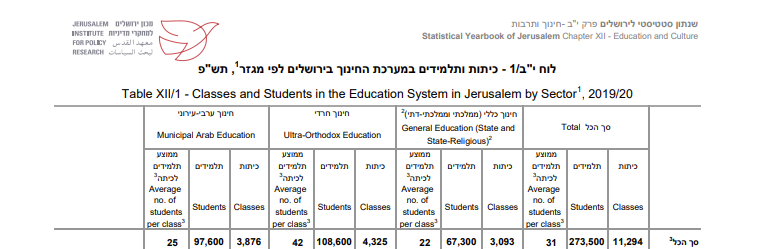

In [59]:
jeru_muni_arab_sum_demand=drop_geo(taz).groupby(by=['CR_PNIM','jew']).sum()[['student_demand']].loc[[3000][0],0].item()

In [60]:
jeru_muni_arab_sum_demand

125858.59175622901

In [61]:
taz=taz.reset_index()

In [62]:
taz.loc[(taz['jew']==0)&( taz['Muni_Heb']=="ירושלים"),'student_demand_pre']=taz['student_demand']/jeru_muni_arab_sum_demand

In [63]:
taz.loc[(taz['jew']==0) &( taz['Muni_Heb']=="ירושלים")]['student_demand_pre'].sum()

0.9999999999999999

In [64]:
taz.loc[(taz['jew']==0) &( taz['Muni_Heb']=="ירושלים"),'cbs_muni_student_left_by_pre_of_demand']=taz['student_demand_pre']*(97600-drop_geo(taz).query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()['student_gov'].loc[0])

In [65]:
taz.loc[ taz['Muni_Heb']=="ירושלים",'cbs_muni_student_left_by_pre_of_demand_left']=0 # בגלל שנתוני מכון ירושלים משמע שבשכת נק' מצאנו יותר תלמידים מאשר המספר הרשמי

In [66]:
drop_geo(taz).query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()[['student_gov','cbs_muni_student_left_by_pre_of_demand_left','cbs_muni_student_left_by_pre_of_demand']]

,student_gov,cbs_muni_student_left_by_pre_of_demand_left,cbs_muni_student_left_by_pre_of_demand
jew,,,
0,58227.000,0.000,39373.000
1,191795.000,0.000,0.000


In [67]:
col=['student_gov','cbs_muni_student_left_by_pre_of_demand_left','cbs_muni_student_left_by_pre_of_demand','student_toddlers']

In [68]:
taz['student_for_Control']=taz[col].sum(axis=1)

In [69]:
drop_geo(taz).query('Muni_Heb=="ירושלים"').groupby(by='jew').sum()[['student_for_Control']]

,student_for_Control
jew,
0,110952.344
1,215239.387


## תלמידים לא במשרד החינוך

In [70]:
taz=taz.set_index('Taz_num')

In [71]:
taz['student_chardi_not_gov']=drop_geo(gpd.sjoin(taz.reset_index(),student_chardi_not_gov)).pivot_table(index='Taz_num',aggfunc=sum)[['num_students']]

C:\Users\dpere\AppData\Local\Temp\ipykernel_28100\809228732.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  taz['student_chardi_not_gov']=drop_geo(gpd.sjoin(taz.reset_index(),student_chardi_not_gov)).pivot_table(index='Taz_num',aggfunc=sum)[['num_students']]


In [72]:
student_arab_not_gov=student_arab_not_gov.pivot_table(index='Taz_num',aggfunc=sum)[['num_student']]

C:\Users\dpere\AppData\Local\Temp\ipykernel_28100\4193798019.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  student_arab_not_gov=student_arab_not_gov.pivot_table(index='Taz_num',aggfunc=sum)[['num_student']]


In [73]:
taz['student_arab_not_gov']=student_arab_not_gov[['num_student']]

## סך תלמידים

In [74]:
taz=taz.fillna(0)

In [75]:
col=['student_for_Control','student_chardi_not_gov','student_arab_not_gov','student_toddlers']

In [76]:
taz['student']=taz[col].sum(axis=1)

## השכלה גבוהה

In [77]:
uni=up_load_df(r'{}\background_files'.format(software_data_folder_location),'uni_students')

In [78]:
uni = gpd.GeoDataFrame(
    uni, geometry= gpd.GeoSeries.from_wkt(uni['geometry']),crs=4326)

In [79]:
uni=uni.to_crs(crs=2039)

In [80]:
uni=uni.fillna(0)

In [81]:
employ_high_edu=up_load_df(r'{}\background_files'.format(software_data_folder_location),'employ_high_edu')

In [82]:
col=['edu_employ',
 'bussines_employ',
 'comm_employ']

In [83]:
employ_high_edu['emp_uni']=employ_high_edu[col].sum(axis=1)

In [84]:
uni=uni.merge(employ_high_edu,on='ID_camp',how='left')

In [85]:
emp_Education_per_uni_student=0.15

In [86]:
uni.loc[uni['emp_uni'].isna(),'emp_uni']=uni['num_students']*emp_Education_per_uni_student

In [87]:
taz['uni_students']=gpd.sjoin(taz[['geometry']].reset_index(),uni)[['Taz_num','num_students']].pivot_table(index='Taz_num',aggfunc=sum)

C:\Users\dpere\AppData\Local\Temp\ipykernel_28100\4121091586.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  taz['uni_students']=gpd.sjoin(taz[['geometry']].reset_index(),uni)[['Taz_num','num_students']].pivot_table(index='Taz_num',aggfunc=sum)


In [88]:
taz['emp_from_uni_student']=gpd.sjoin(taz[['geometry']].reset_index(),uni)[['Taz_num','emp_uni']].pivot_table(index='Taz_num',aggfunc=sum)

C:\Users\dpere\AppData\Local\Temp\ipykernel_28100\2708673975.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  taz['emp_from_uni_student']=gpd.sjoin(taz[['geometry']].reset_index(),uni)[['Taz_num','emp_uni']].pivot_table(index='Taz_num',aggfunc=sum)


In [89]:
taz.loc[taz['main_secto']=="Palestinian",'emp_from_uni_student']=0

In [90]:
taz=taz.fillna(0)

## ישיבות

In [91]:
taz['old_student_yeshiva']=0

taz=taz.fillna(0)



In [92]:
taz=taz.join(student_yeshiva).fillna(0)

In [93]:
taz['add_from_old_student_yeshiva']=taz['old_student_yeshiva']-taz['student_yeshiva']

taz.loc[taz['add_from_old_student_yeshiva']<0,'add_from_old_student_yeshiva']=0

taz['kollim_demand']=(taz['pop_20']*0.8+taz['pop_25']*0.65+taz['pop_30']*0.30+taz['pop_35']*0.30+taz['pop_40']*0.30+taz['pop_45']*0.20+taz['pop_50']*0.20+taz['pop_55']*0.20+taz['pop_60']*0.20)*0.5 #הכפלה בחצי בשביל לקבל אוכלוסיית גברים מעורכת

taz.loc[taz['main_secto']!='U_Orthodox','kollim_demand']=0  #אל אף שאנחנו יודעים שיש כוללים באזורים שהם לא מוגדרים כחרדים

taz['add_from_kollim_demand']=0

taz['student_yeshiva_with_add_from_old']=taz['add_from_old_student_yeshiva']+taz['student_yeshiva']



In [94]:
taz.loc[(taz['main_secto']=='U_Orthodox')&(taz['kollim_demand']>taz['student_yeshiva_with_add_from_old']),'add_from_kollim_demand']=taz['kollim_demand']-taz['student_yeshiva_with_add_from_old']

taz['student_yeshiva_and_kollim']=taz['add_from_kollim_demand']+taz['student_yeshiva_with_add_from_old']

C:\Users\dpere\AppData\Local\Temp\ipykernel_28100\1027504701.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[211.55       311.6        203.4        219.5        344.425
  90.35        56.075       25.39016076  73.20626374  73.23431062
  82.10695662 230.30070665 343.62390833 337.025      366.03886321
 105.80109167 231.87527165  55.25400185  77.16804338 253.975
 271.6075202  128.8788284  132.64795356 192.81912699 152.39663145
  41.96477747  13.99356016  95.41456334 242.36643815 121.83933175
 217.05580154  79.4         61.525      194.025       89.10633285
 261.06314994  13.61840831  66.66415402 125.9366734  493.40591382
  13.875      303.175      179.34455817  52.35639892  74.39291965
 534.43208035 416.82403926 222.70253076 354.0576974  276.
 350.08974276 300.08391068   8.1        103.24850102  62.84563695
 294.26060716 188.67566285  44.13980319 159.3154777  196.63301559
 193.97893162  45.89112945]' has dtype in

## מקדם מועסק חינוך לתלמידים



מקור לנתוני מועסקים בחינוך ירושלים יהודי :https://jerusaleminstitute.org.il/wp-content/uploads/2021/04/shnaton_G0721.pdf

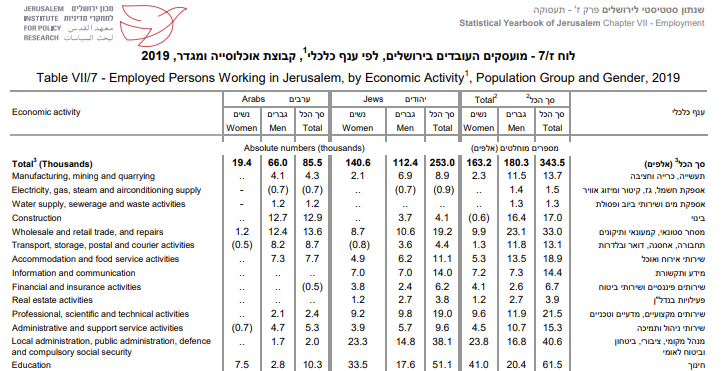

In [95]:
emp_from_uni_student_jeru=taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['emp_from_uni_student']].sum().item()

In [96]:
emp_from_Yeshiva_student_jeru=taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['emp_from_Yeshiva_student']].sum().item()

In [97]:
emp_for_student_jeru_jew=51.1*1000-emp_from_Yeshiva_student_jeru-emp_from_uni_student_jeru

In [98]:
emp_education_per_student=round(taz.query('Muni_Heb=="ירושלים" & jew==1 ')[['student']].sum().item()/emp_for_student_jeru_jew,2) 

In [99]:
emp_education_per_student

6.87

In [100]:
taz['emp_from_student']=taz['student']/emp_education_per_student

In [101]:
taz.loc[taz['main_secto']=="Palestinian",'emp_from_student']=0

In [102]:
taz.query('Muni_Heb=="ירושלים"').groupby(by='jew')[['emp_from_student']].sum()

,emp_from_student
jew,
0,20812.182
1,36281.481


In [103]:
taz['emp_Education']=taz['emp_from_student']+taz['emp_from_Yeshiva_student']+taz['emp_from_uni_student']